<a href="https://colab.research.google.com/github/hdomadia7601/Trading_Paris/blob/main/paris_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install yfinance

In [40]:
!pip install pandas_ta
!pip install pykalman


In [41]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller
import pandas_ta as ta
import statsmodels
import statsmodels.api as sm
import matplotlib.cm as cm
from pykalman import KalmanFilter
import warnings

In [42]:
warnings.filterwarnings('ignore')

In [43]:
start_date = "2017-06-01"
end_date = "2020-06-01"

stocks = ["TATAMOTORS.NS","ASHOKLEY.NS","MARUTI.NS","HEROMOTOCO.NS","MRF.NS","BOSCHLTD.NS","BAJAJ-AUTO.NS","MOTHERSON.NS","EICHERMOT.NS","BALKRISIND.NS","BHARATFORG.NS","M&M.NS","TVSMOTOR.NS"]


In [44]:
stock_data =  yf.download(stocks, start = start_date ,end= end_date)['Adj Close']
stock_data.head()

[*********************100%***********************]  13 of 13 completed


Ticker,ASHOKLEY.NS,BAJAJ-AUTO.NS,BALKRISIND.NS,BHARATFORG.NS,BOSCHLTD.NS,EICHERMOT.NS,HEROMOTOCO.NS,M&M.NS,MARUTI.NS,MOTHERSON.NS,MRF.NS,TATAMOTORS.NS,TVSMOTOR.NS
Date,,,,,,,,,,,,,
2017-06-01 00:00:00+00:00,73.532715,2288.783936,736.292175,569.678711,21756.587891,2511.045654,2923.799072,654.424377,6583.354004,71.030807,67451.117188,473.707214,512.572998
2017-06-02 00:00:00+00:00,74.945259,2299.666016,723.980896,563.678833,21745.675781,2544.769287,3014.958252,651.325012,6553.968262,71.989510,66955.375000,475.794250,518.863098
2017-06-05 00:00:00+00:00,75.066330,2336.383545,731.122070,560.867798,21821.470703,2557.449707,3003.367432,653.712769,6564.101074,72.052902,67566.742188,475.197937,520.879822
2017-06-06 00:00:00+00:00,74.138107,2316.352295,735.248901,551.135803,21648.091797,2545.737305,2975.956787,648.087891,6551.572754,72.528275,68047.539062,458.153839,514.973633
2017-06-07 00:00:00+00:00,74.864548,2318.327148,728.084656,571.875427,21822.705078,2591.260254,3009.867432,657.477844,6637.795898,73.067062,68211.132812,455.172363,514.877808


In [45]:
num_stocks = len(stock_data.columns)
print('Number of Stocks =', num_stocks)

Number of Stocks = 13


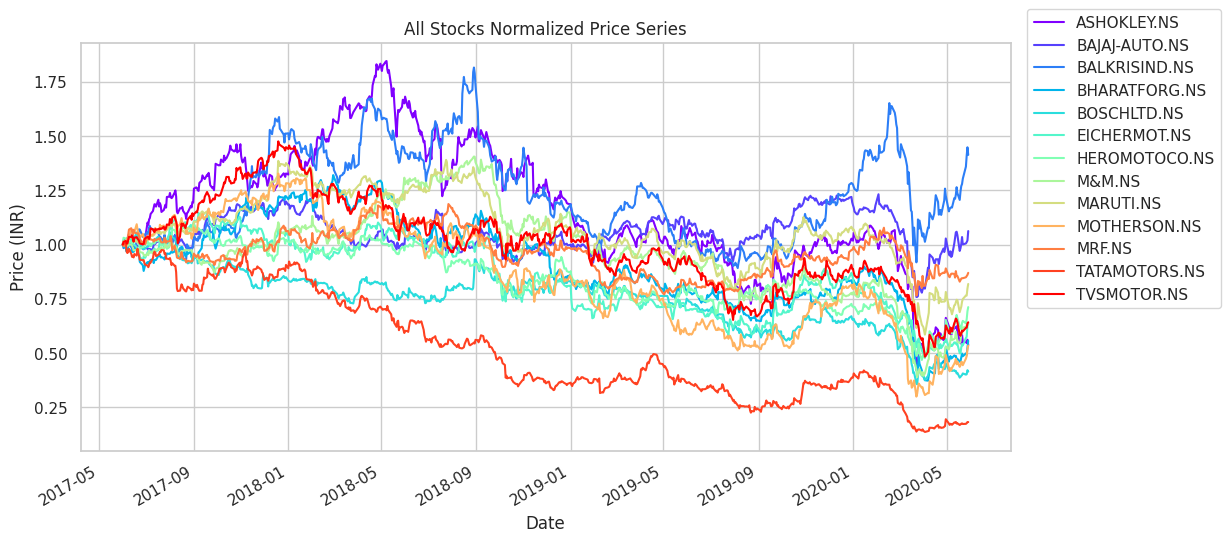

In [47]:
n_secs = len(stock_data.columns)
colors = cm.rainbow(np.linspace(0, 1, n_secs))
stock_data.div(stock_data.iloc[0,:]).plot(color=colors, figsize=(12, 6))# Normalize Prices
plt.title('All Stocks Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Price (INR)')

plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

In [48]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = dataframe.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(stock1, stock2)
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level:
                pairs.append((keys[i], keys[j], pvalue))
    return pvalue_matrix, pairs

In [49]:
df = stock_data
binance_symbols = df.columns
pvalue_matrix, pairs = find_cointegrated_pairs(df)

pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

<Axes: >

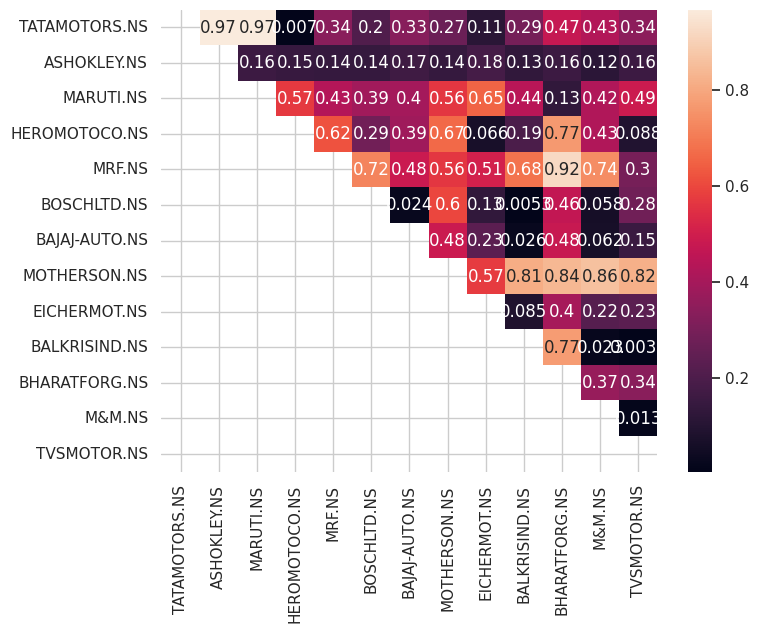

In [50]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalue_matrix_df, xticklabels = stocks, yticklabels = stocks, cmap = 'rocket',  annot = True,mask = (pvalue_matrix_df >= 0.99))

In [51]:
def KalmanFilterAverage(x):

    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)

    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means


In [52]:
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)

    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

In [53]:
def backtest(df,s1, s2):

    x = df[s1]
    y = df[s2]

    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    halflife = half_life(df1['spread'])


    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread


    # trading logic
    entryZscore = 1
    exitZscore = -0.25

    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')


    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')


    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1



    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0


    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start = pd.Timestamp('2017-01-06')
    end = pd.Timestamp('2020-01-06')
    days = (end - start).days
    CAGR = (end_val / start_val) ** (252.0/days) - 1

    df1[s1+ " "+s2+'_cum_rets'] = df1['cum rets']

    return df1[s1+ " "+s2+'_cum_rets'], sharpe, CAGR*100,df1


In [54]:
results = []
for pair in pairs:
    rets, sharpe, CAGR,df1 = backtest(stock_data,pair[0],pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],
                                                                                     round(sharpe,2),
                                                                                     round(CAGR,4)))
    rets0 = pd.concat(results, axis=1)

The pair ASHOKLEY.NS and BHARATFORG.NS produced a Sharpe Ratio of 1.36 and a CAGR of 12.6886
The pair EICHERMOT.NS and HEROMOTOCO.NS produced a Sharpe Ratio of 1.73 and a CAGR of 13.4608
The pair EICHERMOT.NS and MOTHERSON.NS produced a Sharpe Ratio of 0.86 and a CAGR of 9.8706
The pair HEROMOTOCO.NS and MOTHERSON.NS produced a Sharpe Ratio of 1.65 and a CAGR of 16.5777
The pair MOTHERSON.NS and TATAMOTORS.NS produced a Sharpe Ratio of 2.02 and a CAGR of 19.9024
The pair MOTHERSON.NS and TVSMOTOR.NS produced a Sharpe Ratio of 1.38 and a CAGR of 15.1295
The pair TATAMOTORS.NS and TVSMOTOR.NS produced a Sharpe Ratio of 0.85 and a CAGR of 9.4844


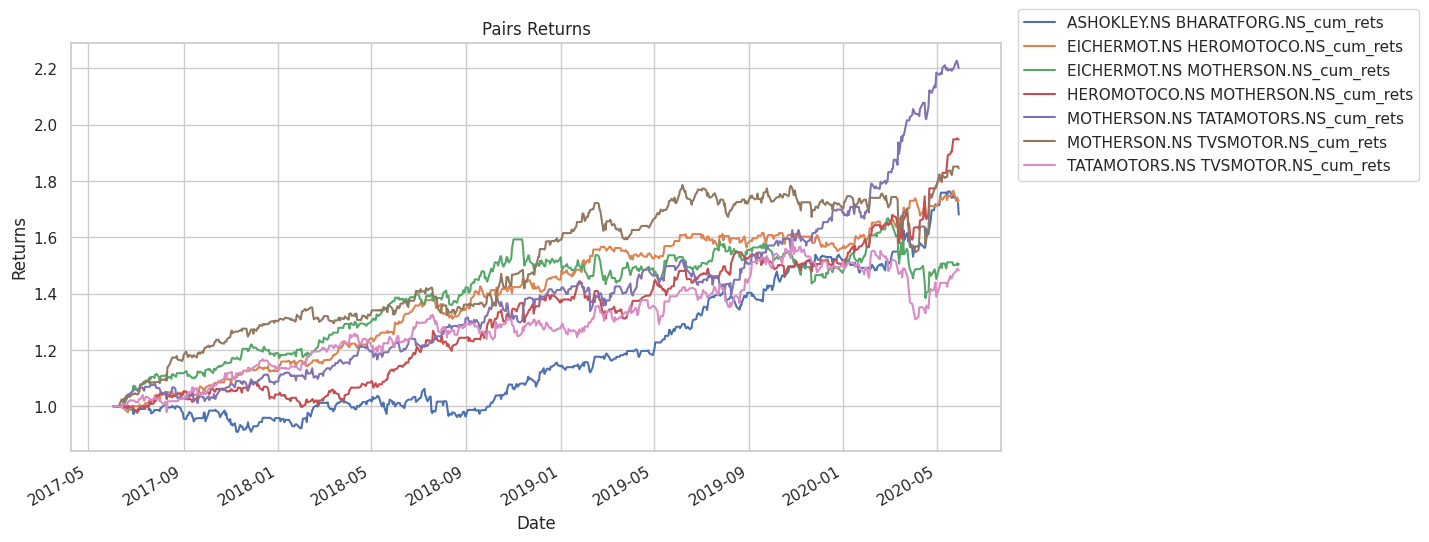

In [55]:
rets0.plot(figsize=(12,6),legend=True)
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns');

In [56]:
stock_pair = ['MOTHERSON.NS', 'TATAMOTORS.NS']
df_new= yf.download(stock_pair, start="2020-07-01" ,end= "2023-07-01")['Adj Close']
x = df_new[stock_pair[0]]
y = df_new[stock_pair[1]]


df_new_2 = pd.DataFrame({'y':y,'x':x})
df_new_2.index = pd.to_datetime(df_new_2.index)
state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
df_new_2['hr'] = - state_means[:,0]
df_new_2['spread'] = df_new_2.y + (df_new_2.x * df_new_2.hr)
halflife = half_life(df_new_2['spread'])

meanSpread = df_new_2.spread.rolling(window=halflife).mean()
stdSpread = df_new_2.spread.rolling(window=halflife).std()
df_new_2['zScore'] = (df_new_2.spread-meanSpread)/stdSpread

entryZscore = 1.5 # 2
exitZscore = 0 # 0
df_new_2['long entry'] = ((df_new_2.zScore < - entryZscore) & ( df_new_2.zScore.shift(1) > - entryZscore))
df_new_2['long exit'] = ((df_new_2.zScore > - exitZscore) & (df_new_2.zScore.shift(1) < - exitZscore))
df_new_2['num units long'] = np.nan
df_new_2.loc[df_new_2['long entry'],'num units long'] = 1
df_new_2.loc[df_new_2['long exit'],'num units long'] = 0
df_new_2['num units long'][0] = 0
df_new_2['num units long'] = df_new_2['num units long'].fillna(method='pad')

#set up num units short
df_new_2['short entry'] = ((df_new_2.zScore > entryZscore) & ( df_new_2.zScore.shift(1) < entryZscore))
df_new_2['short exit'] = ((df_new_2.zScore < exitZscore) & (df_new_2.zScore.shift(1) > exitZscore))
df_new_2.loc[df_new_2['short entry'],'num units short'] = -1
df_new_2.loc[df_new_2['short exit'],'num units short'] = 0
df_new_2['num units short'][0] = 0
df_new_2['num units short'] = df_new_2['num units short'].fillna(method='pad')
df_new_2.dropna(how="any",inplace=True)
df_new_2['numUnits'] = df_new_2['num units long'] + df_new_2['num units short']
df_new_2['spread pct ch'] = (df_new_2['spread'] - df_new_2['spread'].shift(1)) / ((df_new_2['x'] * abs(df_new_2['hr'])) + df_new_2['y'])
df_new_2['port rets'] = df_new_2['spread pct ch'] * df_new_2['numUnits'].shift(1)
df_new_2['cum rets'] = df_new_2['port rets'].cumsum()
df_new_2['cum rets'] = df_new_2['cum rets'] + 1
df_new_2

[*********************100%***********************]  2 of 2 completed


,y,x,hr,spread,zScore,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2020-07-09 00:00:00+00:00,106.289696,38.923111,-2.574401,6.086004,-0.074190,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2020-07-10 00:00:00+00:00,106.935692,38.345146,-2.594329,7.455758,0.281828,False,True,0.0,False,False,0.0,0.0,0.006636,0.000000,1.000000
2020-07-13 00:00:00+00:00,107.333221,38.305283,-2.612840,7.247643,-0.226778,False,False,0.0,False,True,0.0,0.0,-0.001003,-0.000000,1.000000
2020-07-14 00:00:00+00:00,104.500816,37.428368,-2.627958,6.140638,-0.883290,False,False,0.0,False,False,0.0,0.0,-0.005457,-0.000000,1.000000
2020-07-15 00:00:00+00:00,102.562851,37.508087,-2.636688,3.665722,-1.783941,True,False,1.0,False,False,0.0,1.0,-0.012285,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23 00:00:00+00:00,556.194824,82.170753,-6.784895,-1.325076,-1.028142,False,False,1.0,False,False,0.0,1.0,0.001682,0.001682,1.329929
2023-06-26 00:00:00+00:00,564.344116,83.901192,-6.776672,-4.226760,-0.942736,False,False,1.0,False,False,0.0,1.0,-0.002561,-0.002561,1.327368
2023-06-27 00:00:00+00:00,569.561707,84.098953,-6.772243,0.023162,-0.444406,False,False,1.0,False,False,0.0,1.0,0.003731,0.003731,1.331099


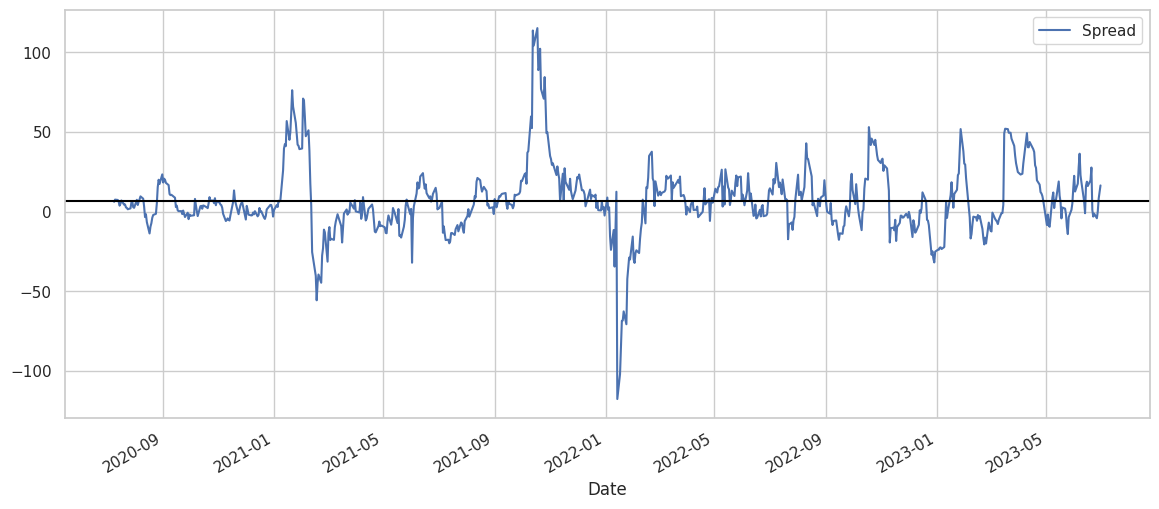

In [57]:
spread = df_new_2["spread"]
spread.plot(figsize=(14, 6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

In [58]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6),dpi=200)
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zScore'], c='#4abdac')
  long_entry = bx.plot(trade_signals['zScore'][trade_signals['long entry'] == True], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  long_exit = bx.plot(trade_signals['zScore'][trade_signals['long exit'] == True], lw = 0, marker = 'v', markersize = 8, c = 'orange', alpha = 0.9)
  short_entry = bx.plot(trade_signals['zScore'][trade_signals["short entry"]== True], lw = 0, marker = '^', markersize = 8, c = 'black', alpha = 0.9)
  short_exit = bx.plot(trade_signals['zScore'][trade_signals["short exit"]== True], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  stock1 = stock_pair[0]
  stock2 = stock_pair[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'Long Entry', 'Long Exit','Short Entry',"Short Exit"])

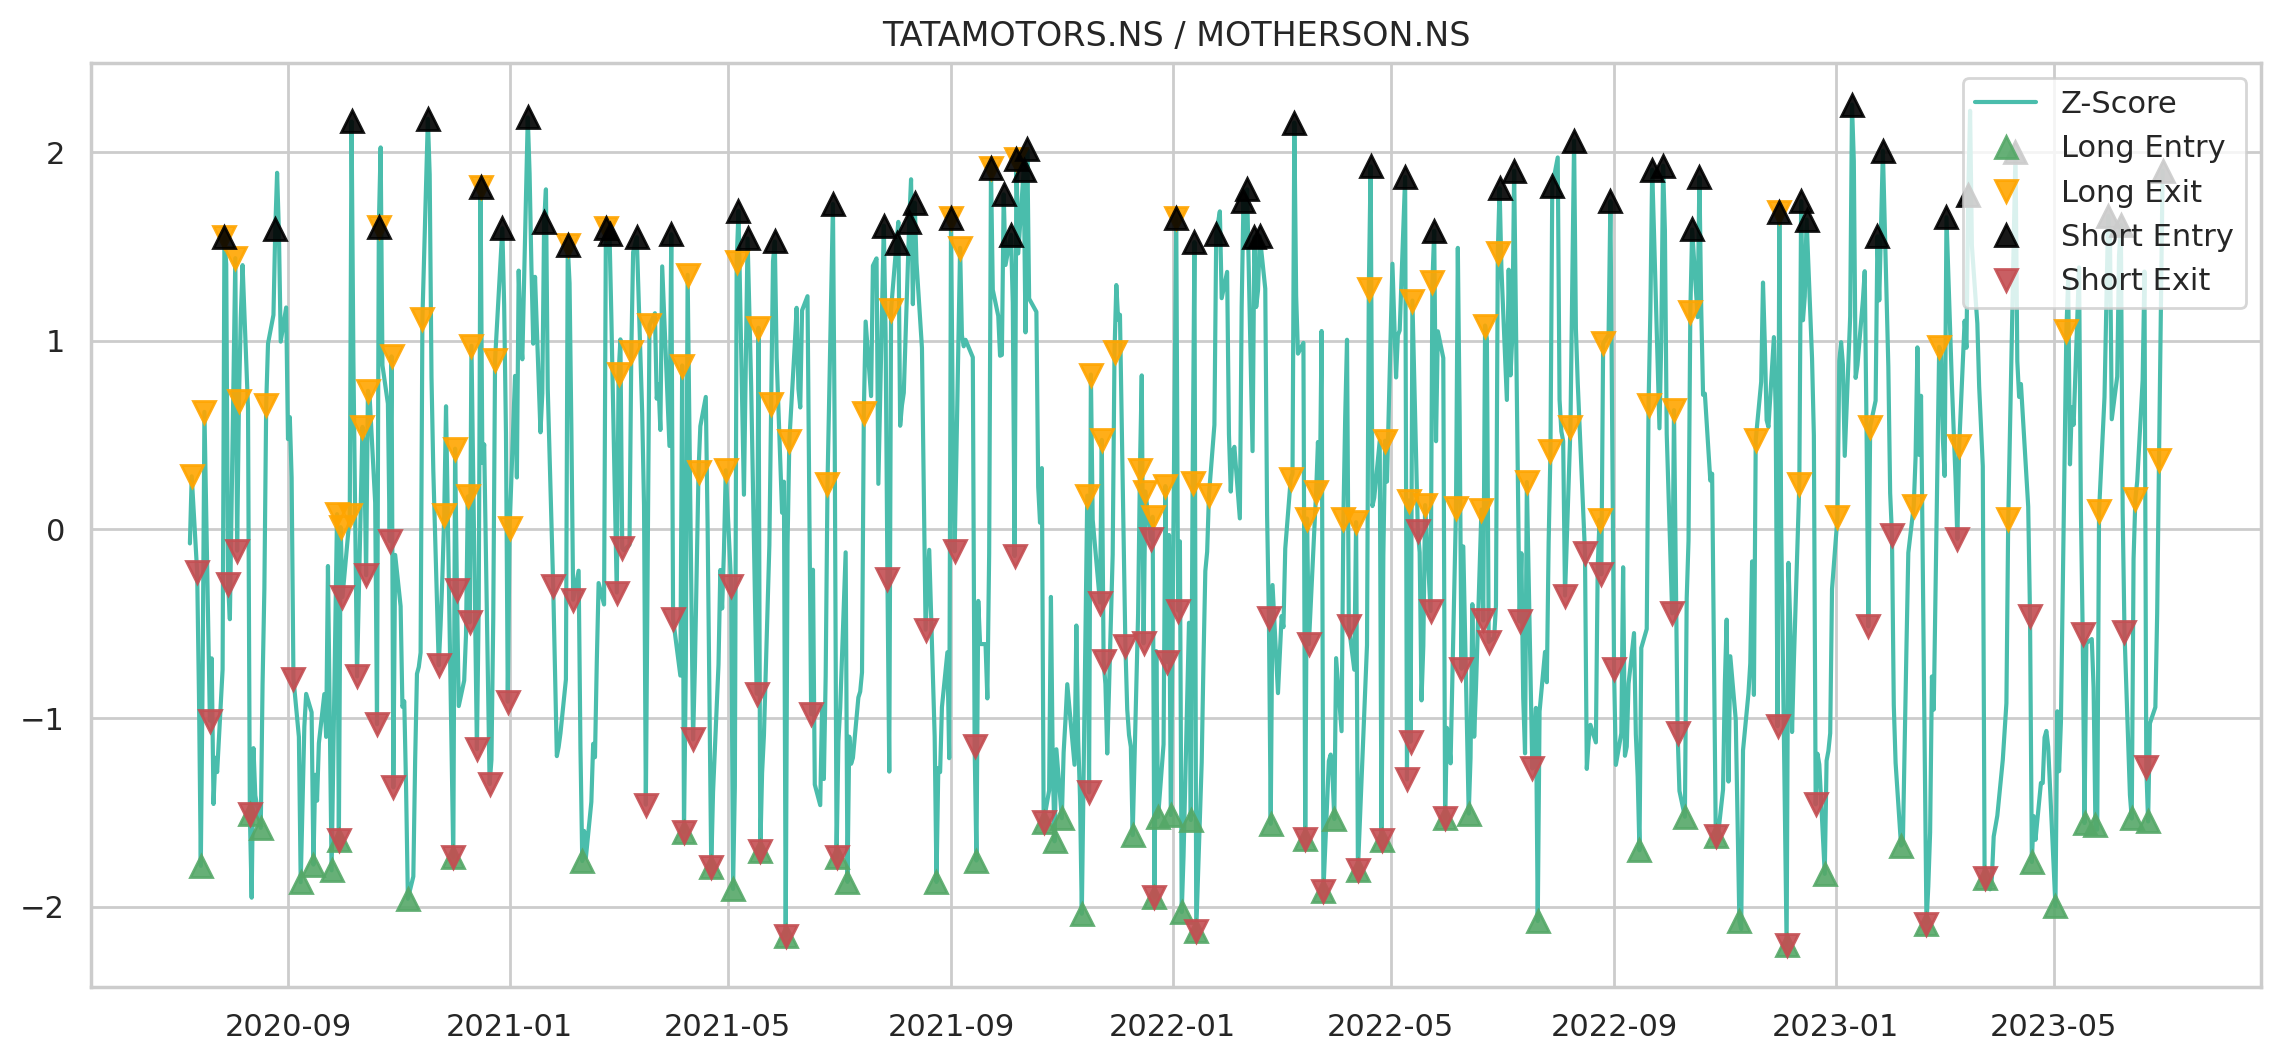

In [59]:
plot_pair_trades(df_new_2)

In [60]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['y'], c='#4abdac')
  u1 = bx.plot(signals['y'][signals['long entry'] == True], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['y'][signals['short entry'] == True], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[0])
  plt.legend(['Price', 'Long', 'Short'])

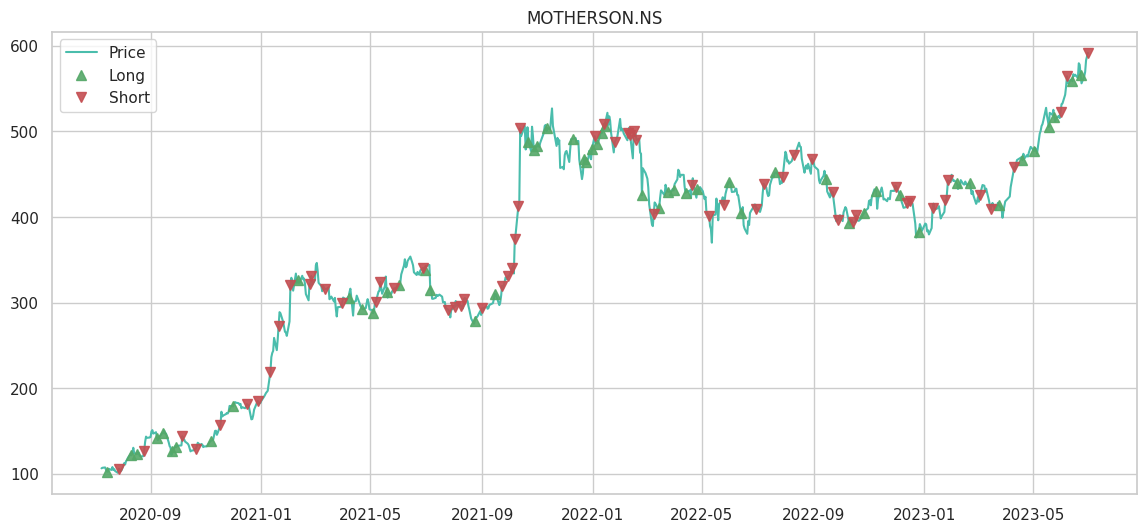

In [61]:
plot_trades_1(df_new_2)

In [62]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['x'], c='#4abdac')
  u1 = bx.plot(signals['x'][signals['long entry'] == True], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['x'][signals['short entry'] == True], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[1])
  plt.legend(['Price', 'Long', 'Short'])

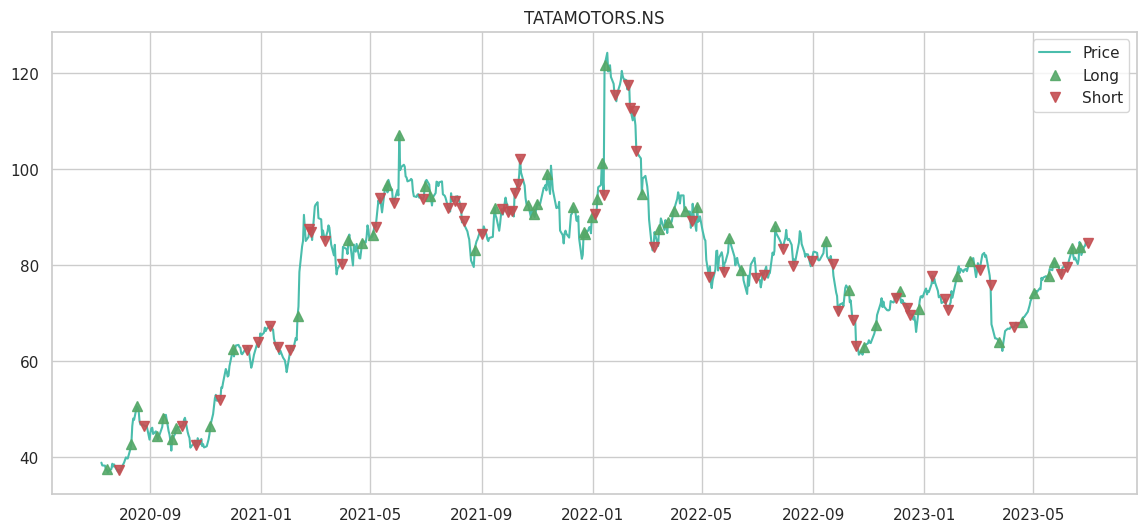

In [63]:
plot_trades_2(df_new_2)

In [64]:
def pnl_calculation(signals):

  initial_capital = 100000


  shares1 = initial_capital// (signals['x'][0])
  shares2 = initial_capital// (signals['y'][0])


  portfolio = pd.DataFrame()
  portfolio['holdings1'] = (signals['long entry']).cumsum() * signals['x'] * shares1
  portfolio['cash1'] = initial_capital - (signals['long entry'] * signals['x'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()


  portfolio['holdings2'] = signals['long exit'].cumsum() * signals['y'] * shares2
  portfolio['cash2'] = initial_capital - (signals['long exit'] * signals['y'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()


  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio

In [72]:
def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])



**Portfolio Performance**

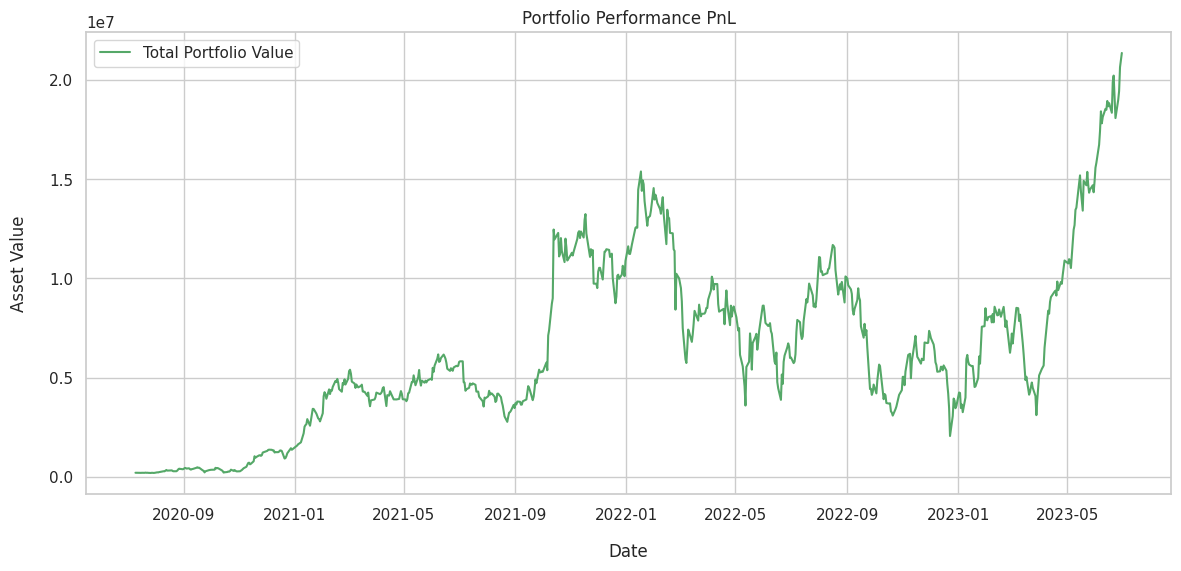

In [74]:


portfolio = pnl_calculation(df_new_2)
plot_portfolio_value(portfolio)


**Cumumlative Returns**

<Axes: xlabel='Date'>

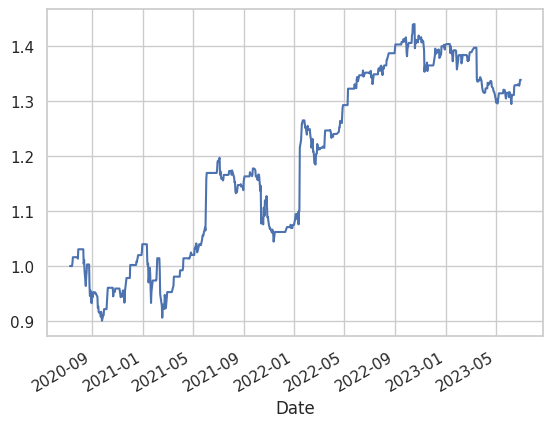

In [75]:
df_new_2["cum rets"].plot()